# Joint fitting XRT and GBM data with XSPEC models

### Goals

3ML is designed to properly joint fit data from different instruments with thier instrument dependent likelihoods.
We demostrate this with joint fitting data from GBM and XRT while simultaneously showing hwo to use the XSPEC models form **astromodels**

### Setup

You must have you HEASARC initiated so that **astromodels** can find the XSPEC libraries. 




In [1]:
%matplotlib inline
%matplotlib notebook
from threeML import *
import os

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


## Load XRT data

Make a likelihood for the XRT including all the appropriate files

Auto-probed noise models:
- observation: poisson
- background: poisson


<IPython.core.display.Javascript object>


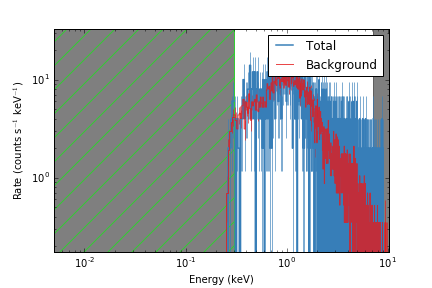

In [3]:
trigger="GRB110731A"
dec=-28.546
ra=280.52
xrt_dir='xrt'
xrt = SwiftXRTLike("XRT",pha_file=os.path.join(xrt_dir,"xrt_src.pha"),
                   bak_file=os.path.join(xrt_dir,"xrt_bkg.pha"),
                   rsp_file=os.path.join(xrt_dir,"xrt.rmf"),
                   arf_file=os.path.join(xrt_dir,"xrt.arf"))



xrt.view_count_spectrum()

## Load GBM data

Load all the GBM data you need and make appropriate background, source time, and energy selections. Make sure to check the light curves! 

In [9]:

data_dir_gbm=os.path.join('gbm','bn110731A')
trigger_number = 'bn110731465'
gbm_data = download_GBM_trigger_data(trigger_number,detectors=['n3'],destination_directory=data_dir_gbm,compress_tte=True)

# Select the time interval
src_selection = "100.169342-150.169342"

nai3 = FermiGBMTTELike('NAI3',
                         os.path.join(data_dir_gbm,"glg_tte_n3_bn110731465_v00.fit.gz"),
                         "20-90,160-250", # background selection
                         src_selection,          # source interval
                         rsp_file=os.path.join(data_dir_gbm, "glg_cspec_n3_bn110731465_v00.rsp2"))


glg_cspec_n3_bn110731465_v00.rsp2 already downloaded into /Users/jburgess/coding/3ML/examples/gbm/bn110731A -> skipping
glg_tte_n3_bn110731465_v00.fit.gz already downloaded into /Users/jburgess/coding/3ML/examples/gbm/bn110731A -> skipping
Auto-determined polynomial order: 1


Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-probed noise models:
- observation: poisson
- background: gaussian


View the light curve

<IPython.core.display.Javascript object>


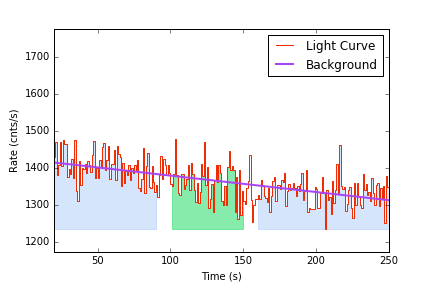

In [10]:
nai3.view_lightcurve(20,250)

Make energy selections and check them out

Range 8-900 translates to channels 4-123
Now using 120 channels out of 128


<IPython.core.display.Javascript object>


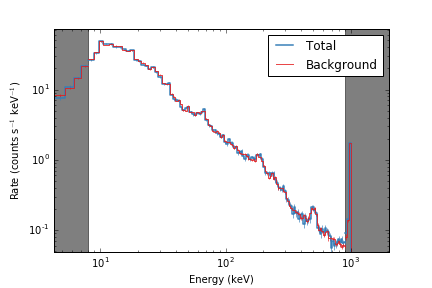

In [11]:
nai3.set_active_measurements("8-900")
nai3.view_count_spectrum()

## Setup the model

**astromodels** allows you to use XSPEC models if you have XSPEC installed.
Set all the normal parameters you would in XSPEC and build a model the normal **3ML/astromodel** way!


In [6]:
xspec_abund('angr')

spectral_model =  XS_phabs()* XS_zphabs() * XS_powerlaw()


spectral_model.nh_1=0.101
spectral_model.nh_1.fix = True

spectral_model.nh_2=0.1114424
spectral_model.nh_2.fix = True

spectral_model.redshift_2 = 0.618
spectral_model.redshift_2.fix =True

In [7]:
spectral_model.display()

* description: ((XS_phabs{1} * XS_zphabs{2}) * XS_powerlaw{3})
  * formula: (no latex formula available)
  * parameters: 
    * nh_1: 
      * value: 0.101
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * nh_2: 
      * value: 0.1114424
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * redshift_2: 
      * value: 0.618
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -0.999
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: False
    * phoindex_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -3.0
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: True
    * norm_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: None
      * unit: keV / (cm2 s)
      * delta: 0.1
      * free: True

## Setup the joint likelihood

Create a point source object and model. 

Load the data into a data list and create the joint likelihood


In [8]:
ptsrc = PointSource(trigger,ra,dec,spectral_shape=spectral_model)
model = Model(ptsrc)

In [9]:
data = DataList(xrt,nai3)

jl = JointLikelihood(model, data, verbose=False)
model.display()

name,value,min_value,max_value,unit,delta,free
GRB110731A.spectrum.main.composite.phoindex_3,1.0,-3.0,10.0,,0.01,True
GRB110731A.spectrum.main.composite.norm_3,1.0,0.0,None,keV / (cm2 s),0.1,True


## Fitting

### Maximum Likelihood style

In [10]:
res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,GRB110731A.spectrum.main.composite.phoindex_3,2.05 +/- 0.05,
1,GRB110731A.spectrum.main.composite.norm_3,0.209 +/- 0.008,keV / (cm2 s)



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.59
0.59,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2528.925579
XRT,1634.050459
NAI3,894.875120


In [11]:
res = jl.get_errors()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.05 -0.05 +0.06,
GRB110731A.spectrum.main.composite.norm_3,0.209 -0.008 +0.009,keV / (cm2 s)


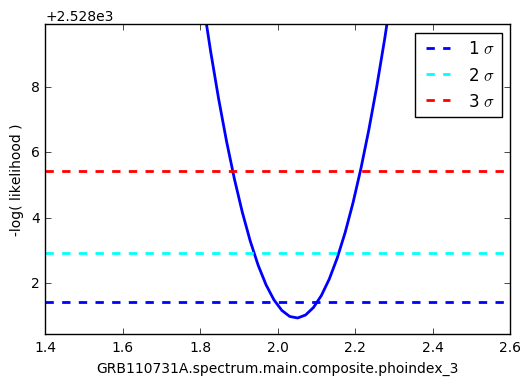

In [12]:
res = jl.get_contours(spectral_model.phoindex_3,1.5,2.5,50)

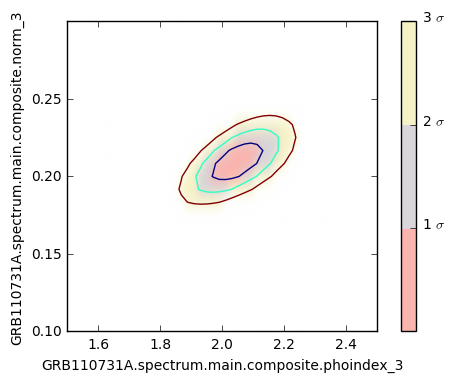

In [13]:
res = jl.get_contours(spectral_model.norm_3,.1,.3,25,spectral_model.phoindex_3,1.5,2.5,50)

### And then go Bayesian!

In [14]:
spectral_model.phoindex_3.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
spectral_model.norm_3.prior = Log_uniform_prior(lower_bound=1E-5, upper_bound=1)

In [15]:
bayes = BayesianAnalysis(model, data)

In [16]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.71478


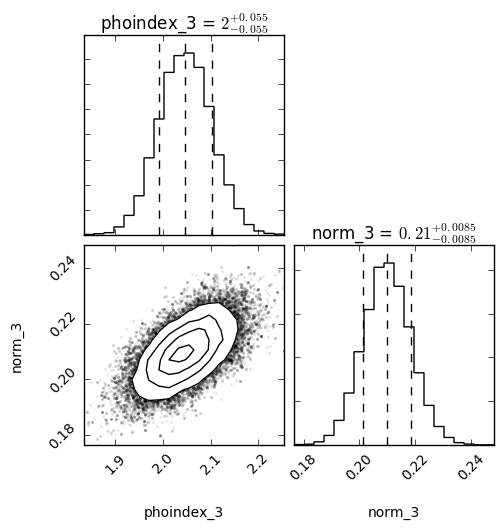

In [17]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)


In [18]:
bayes.get_highest_density_interval()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.05 -0.11 +0.11,
GRB110731A.spectrum.main.composite.norm_3,0.210 -0.017 +0.017,keV / (cm2 s)


OrderedDict([('GRB110731A.spectrum.main.composite.phoindex_3',
              {'lower bound': 1.9378758501195972,
               'median': 2.0470182213962556,
               'upper bound': 2.1544203775899127}),
             ('GRB110731A.spectrum.main.composite.norm_3',
              {'lower bound': 0.19310005904270033,
               'median': 0.20986057245173392,
               'upper bound': 0.22669524128769092})])

In [12]:
cleanup_downloaded_GBM_data(gbm_data)

Removing: /Users/jburgess/coding/3ML/examples/gbm/bn110731A/glg_cspec_n3_bn110731465_v00.rsp2
Removing: /Users/jburgess/coding/3ML/examples/gbm/bn110731A/glg_tte_n3_bn110731465_v00.fit.gz


